In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import wget
import os
import sys

In [2]:
def bar_progress(current, total, width=80):
  progress_message = f"Downloading: {current / total * 100} [{current} / {total}] bytes"
  # Don't use print() as it will print in new line every time.
  sys.stdout.write("\r" + progress_message)
  sys.stdout.flush()

url = "https://drive.google.com/u/0/uc?id=1cnE-XBZlDGAIZtGbvA5ra07KyRRacWDU&export=download&confirm=t"
cur_dir = os.getcwd()
file_path = cur_dir+"\depression.csv"
if not os.path.exists(file_path):
    wget.download(url, file_path, bar=bar_progress)

In [3]:
sample_size = 10 # enter sample size in terms of percentage where 100% is 1600000 tweets
epochs = 10 # enter preferred number of epochs

In [4]:
data = pd.read_csv("depression.csv", encoding='latin-1')
data.columns = ["target", "id", "date", "flag", "user", "text"]
data.head(5)

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data.drop(["id", "date", "flag", "user"], axis=1, inplace=True)
data.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


<AxesSubplot: >

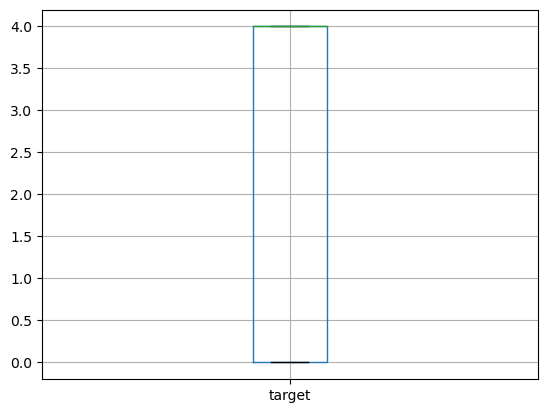

In [6]:
plt.figure()
data.boxplot(column="target")

<AxesSubplot: >

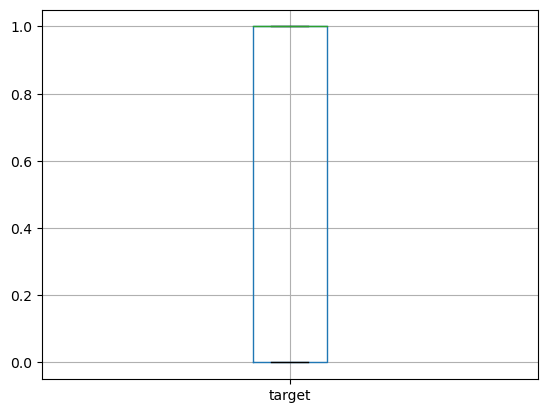

In [7]:
data['target'] = data['target'] / 4
plt.figure()
data.boxplot(column="target")

In [8]:
data = shuffle(data)
data.head()

,target,text
750221,0.0,@yadikeith I am still on lots of meda Have br...
1527187,1.0,@freshstate ive seen the episode. it was a pra...
1217087,1.0,is going home... http://plurk.com/p/xlf3w
1133958,1.0,"@ajdixon No solution that I know of, but if I ..."
1120411,1.0,@thekelliejane Glad to hear you are ok.


In [9]:
data = data.iloc[:int(1600000*(sample_size/100))]

In [10]:
feature = data['text'].to_numpy()
target = data['target'].to_numpy()

In [11]:
X, X_test, y, y_test = train_test_split(feature, target, test_size=0.2, shuffle=True, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=8)

In [12]:
print("Sample size for Training", len(X_train))
print("Sample size for Validation", len(X_val))
print("Sample size for Testing", len(X_test))

Sample size for Training 96000
Sample size for Validation 32000
Sample size for Testing 32000


In [13]:
max_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [14]:
vectorize_layer.adapt(X_train)

In [15]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [16]:
first_tweet = feature[0]
print(first_tweet)
a = vectorize_text(first_tweet)
a

@yadikeith I am still on lots of meda  Have bronchial pneumonia...not fun! What is going on with hubby?


<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  1,   2,  61,  69,  15, 446,  13,   1,  18,   1,   1, 112,  59,
          9,  47,  15,  22, 986,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

In [17]:
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [19]:
history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val,y_val),
        epochs=epochs)

Epoch 1/10
3000/3000 [==============================] - 35s 11ms/step - loss: 0.6739 - accuracy: 0.5040 - val_loss: 0.6344 - val_accuracy: 0.5463
Epoch 2/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5948 - accuracy: 0.6261 - val_loss: 0.5666 - val_accuracy: 0.7092
Epoch 3/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.5414 - accuracy: 0.7059 - val_loss: 0.5272 - val_accuracy: 0.7243
Epoch 4/10
3000/3000 [==============================] - 34s 11ms/step - loss: 0.5104 - accuracy: 0.7376 - val_loss: 0.5066 - val_accuracy: 0.7459
Epoch 5/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.4920 - accuracy: 0.7540 - val_loss: 0.4976 - val_accuracy: 0.7380
Epoch 6/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.4805 - accuracy: 0.7651 - val_loss: 0.4907 - val_accuracy: 0.7477
Epoch 7/10
3000/3000 [==============================] - 26s 9ms/step - loss: 0.4722 - accuracy: 0.7721 - val_loss: 0.4853 - va

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)

1000/1000 [==============================] - 3s 3ms/step - loss: 0.4819 - accuracy: 0.7807


In [21]:
model.predict([["I am feeling good"],["I am very Happy"]])

1/1 [==============================] - 0s 358ms/step


array([[0.38171586],
       [1.5897564 ]], dtype=float32)

In [26]:
history.history

{'loss': [0.6740783452987671,
  0.5928030610084534,
  0.5382823944091797,
  0.5071399807929993,
  0.4890005588531494,
  0.47698450088500977,
  0.4685118794441223,
  0.46214592456817627,
  0.4574865698814392,
  0.4527910649776459],
 'accuracy': [0.5041666626930237,
  0.6308749914169312,
  0.7098437547683716,
  0.741447925567627,
  0.7565521001815796,
  0.7669166922569275,
  0.7738958597183228,
  0.7796041369438171,
  0.7825208306312561,
  0.7877187728881836],
 'val_loss': [0.6380774974822998,
  0.5668313503265381,
  0.5322263836860657,
  0.51096510887146,
  0.504511296749115,
  0.495553582906723,
  0.4916744530200958,
  0.4919338524341583,
  0.48894229531288147,
  0.49594199657440186],
 'val_accuracy': [0.5989375114440918,
  0.6982499957084656,
  0.7384374737739563,
  0.7416874766349792,
  0.7246562242507935,
  0.758187472820282,
  0.7566562294960022,
  0.7435312271118164,
  0.7700312733650208,
  0.7795000076293945]}